In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import dowhy
import matplotlib as plt

from dowhy import gcm
from dowhy import CausalModel

In [3]:
data_path = '../../data/payments_phoenix_2022_processed.csv'
df = pd.read_csv(data_path)

Creating Causal Graph

In [4]:
columns = df.columns

In [5]:
columns

Index(['Unnamed: 0', 'Name', 'Department', 'Job Title', 'Full/Part Time',
       'Hourly Rate', 'Regular Pay', 'Overtime Pay', 'Other Pay',
       'Benefits_Category', 'Hire_Date', 'Termination_Date', 'working_months',
       'antiguity_months'],
      dtype='object')

In [6]:
df_causal = df[columns[2:]].copy()
df_causal.head()

,Department,Job Title,Full/Part Time,Hourly Rate,Regular Pay,Overtime Pay,Other Pay,Benefits_Category,Hire_Date,Termination_Date,working_months,antiguity_months
0,Police Department,Police Officer,F,37.79,71560.00,0.00,5238.09,4.0,1991-07-15,2022-01-01,365.609150,365.609150
1,Police Department,Police Officer,F,30.04,58472.80,2480.96,1490.57,4.0,2018-12-17,2022-01-01,36.501776,36.501776
2,Fire Department,Firefighter 56hr,F,24.48,65584.91,18186.03,1329.91,5.0,2008-01-14,2022-01-01,167.592764,167.592764
3,Police Department,Forensic Scientist IV,F,51.02,104979.20,0.00,1175.32,7.0,2009-12-28,2022-01-01,144.134376,144.134376
4,Parks & Recreation: Aquatics,Parks & Recreation Aide*Cash,P,12.92,5131.92,259.68,75.00,998.0,2010-04-19,2022-01-01,140.454629,140.454629


In [7]:
causal_columns = ['Department','Job Title', 'Full/Part Time', 'Hourly Rate', 'antiguity_months']
df_causal = df_causal[causal_columns]
df_causal.head()

,Department,Job Title,Full/Part Time,Hourly Rate,antiguity_months
0,Police Department,Police Officer,F,37.79,365.609150
1,Police Department,Police Officer,F,30.04,36.501776
2,Fire Department,Firefighter 56hr,F,24.48,167.592764
3,Police Department,Forensic Scientist IV,F,51.02,144.134376
4,Parks & Recreation: Aquatics,Parks & Recreation Aide*Cash,P,12.92,140.454629


In [8]:
cat_columns = ['Department','Job Title', 'Full/Part Time']
df_causal[cat_columns] = df_causal[cat_columns].astype('category')
df_causal.loc[df_causal['Full/Part Time'] == "F", "FullPartTime"] = 1.0
df_causal.loc[df_causal['Full/Part Time'] == "P", "FullPartTime"] = 0.0
df_causal[0:10]

,Department,Job Title,Full/Part Time,Hourly Rate,antiguity_months,FullPartTime
0,Police Department,Police Officer,F,37.79,365.609150,1.0
1,Police Department,Police Officer,F,30.04,36.501776,1.0
2,Fire Department,Firefighter 56hr,F,24.48,167.592764,1.0
3,Police Department,Forensic Scientist IV,F,51.02,144.134376,1.0
4,Parks & Recreation: Aquatics,Parks & Recreation Aide*Cash,P,12.92,140.454629,0.0
5,Human Services Department,Secretary II,F,15.98,24.082630,1.0
6,Street Transportation Dept,Environmental Quality Spec,F,41.78,63.639910,1.0
7,Planning & Development Dept,Chief Engineering Tech*U7,F,23.58,63.179942,1.0
8,Public Transit,Municipal Security Guard,F,22.64,38.801618,1.0
9,Water Services Department,GIS Coordinator,F,43.92,272.465554,1.0


In [9]:
df_causal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15083 entries, 0 to 15082
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Department        15082 non-null  category
 1   Job Title         15082 non-null  category
 2   Full/Part Time    15082 non-null  category
 3   Hourly Rate       15082 non-null  float64 
 4   antiguity_months  15082 non-null  float64 
 5   FullPartTime      15082 non-null  float64 
dtypes: category(3), float64(3)
memory usage: 436.1 KB


In [10]:
df_causal['FullPartTime'].describe()


count    15082.000000
mean         0.904257
std          0.294249
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: FullPartTime, dtype: float64

In [27]:
df_causal = df_causal.dropna()
df_causal['FullPartTime'].unique()

array([1., 0.])

In [16]:
df_jobtitle.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 764 entries, Account Clerk II to Youth Services Coordinator
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Department        764 non-null    int64
 1   Full/Part Time    764 non-null    int64
 2   Hourly Rate       764 non-null    int64
 3   antiguity_months  764 non-null    int64
 4   FullPartTime      764 non-null    int64
dtypes: int64(5)
memory usage: 53.5 KB


In [17]:
causal_graph = nx.DiGraph()


In [18]:
causal_graph.add_edges_from([('Department', 'Job Title'), ('Job Title', 'Hourly Rate'), ('FullPartTime', 'Hourly Rate'),
                ('Department', 'FullPartTime'), ('antiguity_months', 'Hourly Rate')])

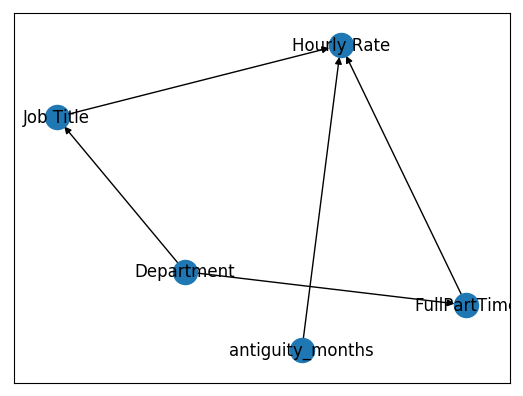

In [19]:

nx.draw_networkx(causal_graph, with_labels = True, arrows = True)


I want to measure the arrow strenghs:

1. using DoWhy
2. using GMC

Then.. can I do it with a non-binary variable?

**We have to simplify the model since dowhy per se only work with numerical values. Steps:**

1. Simplified model with DoWhy and GMC
2. One-hot encoding of the department
3. Using EconML for categorical variables
4. Using CausalML for categorical variables
5. Using GMC
6. Conclusions

In [20]:
graph_string = """graph [
  directed 1
  node [
    id 0
    label "antiguity_months"
  ]
  node [
    id 1
    label "Hourly Rate"
  ]
  node [
    id 2
    label "FullPartTime"
  ]
  node [
    id 3
    label "Job Title"
  ]
  node [
    id 4
    label "Department"
  ]
  edge [
    source 0
    target 1
  ]
  edge [
    source 2
    target 1
  ]
  edge [
    source 3
    target 1
  ]
  edge [
    source 4
    target 3
  ]
  edge [
    source 4
    target 2
  ]
]

"""

In [22]:
graph_string_simple_1 = """graph [
  directed 1
  node [
    id 0
    label "antiguity_months"
  ]
  node [
    id 1
    label "Hourly Rate"
  ]
  node [
    id 2
    label "FullPartTime"
  ]
  edge [
    source 0
    target 1
  ]
  edge [
    source 2
    target 1
  ]
]

"""

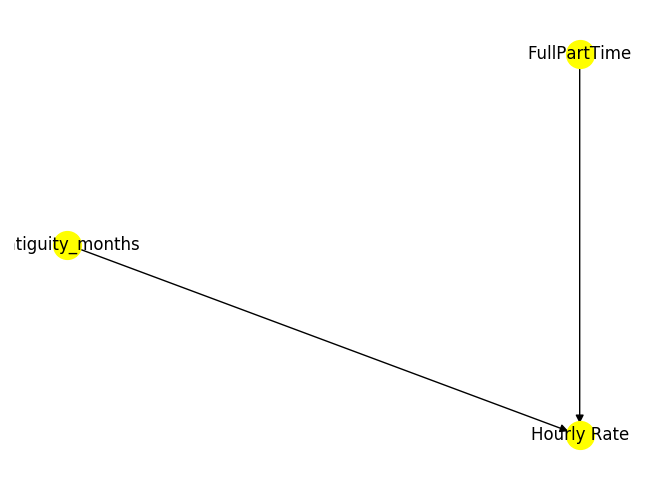

In [28]:
model = CausalModel(
        data = df_causal,
        treatment = 'FullPartTime',
        outcome = 'Hourly Rate',
        graph = graph_string_simple_1 
        )
model.view_model()

In [29]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True, method_name="maximal-adjustment")
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                       
───────────────(E[Hourly Rate])
d[FullPartTime]                
Estimand assumption 1, Unconfoundedness: If U→{FullPartTime} and U→Hourly Rate then P(Hourly Rate|FullPartTime,,U) = P(Hourly Rate|FullPartTime,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [30]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['antiguity_months']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                       
───────────────(E[Hourly Rate])
d[FullPartTime]                
Estimand assumption 1, Unconfoundedness: If U→{FullPartTime} and U→Hourly Rate then P(Hourly Rate|FullPartTime,,U) = P(Hourly Rate|FullPartTime,)

## Realized estimand
b: Hourly Rate~FullPartTime+FullPartTime*antiguity_months
Target units: ate

## Estimate
Mean value: 14.113457003531575
p-value: [7.02794453e-161]
### Conditional Estimates
__categorical__antiguity_months
(0.623, 33.282]        9.140151
(33.282, 74.219]      10.567683
(74.219, 180.012]     13.604722
(180.012, 251.767]    16.735689
(251.767, 576.965]    20.603251
dtype: f

/Users/ESMoraEn/opt/anaconda3/envs/dowhy/lib/python3.7/site-packages/dowhy/causal_estimator.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_quantiles, duplicates="drop")


In [31]:
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 14.113457003531575


**The effect of to have a Full Time job, in avergage, increases the hourly rate by 14.11 USD, and it is clearly affected by the antiguity**

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                         
──────────────────(E[Hourly Rate])
d[antiguityₘₒₙₜₕₛ]                
Estimand assumption 1, Unconfoundedness: If U→{antiguity_months} and U→Hourly Rate then P(Hourly Rate|antiguity_months,,U) = P(Hourly Rate|antiguity_months,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['FullPartTime']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                         
──────────────────(E[Hourly Rate])
d[antiguityₘₒₙₜₕₛ]                
Estimand assumption 1, Unconfoundedness: If

/Users/ESMoraEn/opt/anaconda3/envs/dowhy/lib/python3.7/site-packages/dowhy/causal_estimator.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_quantiles, duplicates="drop")


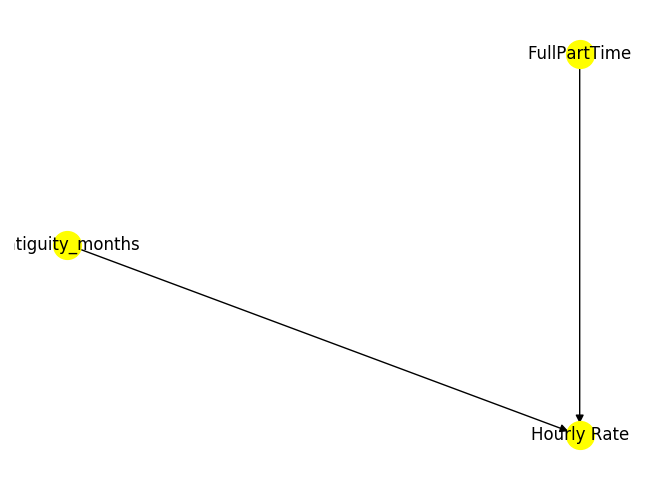

In [33]:
model_ant = CausalModel(
        data = df_causal,
        treatment = 'antiguity_months',
        outcome = 'Hourly Rate',
        graph = graph_string_simple_1 
        )
model_ant.view_model()
#Identify the causal effect
identified_estimand_ant = model_ant.identify_effect(proceed_when_unidentifiable=True, method_name="maximal-adjustment")
print(identified_estimand_ant)
# Estimate the causal effect and compare it with Average Treatment Effect
estimate_ant = model_ant.estimate_effect(identified_estimand_ant,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate_ant)


**But it looks like Antiguity does not affect too much to the hourly rate ???** 

Let's repite the expiremnt with GCM

What will happen to the variable Z if I intervene on Y?

This intervention says: "I'll ignore any causal effects of X on Y, and set every value of Y to 2.34." So the distribution of X will remain unchanged, whereas values of Y will be at a fixed value and Z will respond according to its causal model.

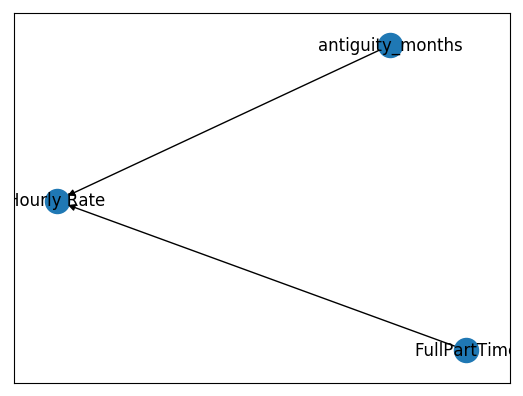

In [54]:
causal_graph = nx.DiGraph()
causal_graph.add_edges_from([('FullPartTime', 'Hourly Rate'),
                             ('antiguity_months', 'Hourly Rate')])
nx.draw_networkx(causal_graph, with_labels = True, arrows = True)

In [55]:
causal_model = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model, df_causal)

In [56]:
gcm.fit(causal_model, df_causal)

Fitting causal mechanism of node antiguity_months: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 212.03it/s]


In [57]:
samples = gcm.interventional_samples(causal_model,
                                     {'antiguity_months': lambda y: 120 },
                                     num_samples_to_draw=1000)
samples[0:10]

,FullPartTime,antiguity_months,Hourly Rate
0,1.0,120,38.259073
1,1.0,120,24.553412
2,1.0,120,49.631919
3,1.0,120,23.129373
4,1.0,120,23.198224
5,1.0,120,22.372907
6,1.0,120,61.291672
7,1.0,120,43.771672
8,1.0,120,21.450211
9,1.0,120,23.088761


In [58]:
df_causal[0:10]

,Department,Job Title,Full/Part Time,Hourly Rate,antiguity_months,FullPartTime
0,Police Department,Police Officer,F,37.79,365.609150,1.0
1,Police Department,Police Officer,F,30.04,36.501776,1.0
2,Fire Department,Firefighter 56hr,F,24.48,167.592764,1.0
3,Police Department,Forensic Scientist IV,F,51.02,144.134376,1.0
4,Parks & Recreation: Aquatics,Parks & Recreation Aide*Cash,P,12.92,140.454629,0.0
5,Human Services Department,Secretary II,F,15.98,24.082630,1.0
6,Street Transportation Dept,Environmental Quality Spec,F,41.78,63.639910,1.0
7,Planning & Development Dept,Chief Engineering Tech*U7,F,23.58,63.179942,1.0
8,Public Transit,Municipal Security Guard,F,22.64,38.801618,1.0
9,Water Services Department,GIS Coordinator,F,43.92,272.465554,1.0


Can we measure the arrow strengh?

In [59]:
strength = gcm.arrow_strength(causal_model, 'Hourly Rate')

In [60]:
strength

{('FullPartTime', 'Hourly Rate'): 10.597201606179864,
 ('antiguity_months', 'Hourly Rate'): 17.91207512904539}

In [66]:
gcm.average_causal_effect(causal_model,
                         'Hourly Rate',
                         interventions_alternative={'FullPartTime': lambda x: 1},
                         interventions_reference={'FullPartTime': lambda x: 0},
                         num_samples_to_draw=1000)

It is consistent with the computations from DoWhy (more or less)

In [69]:
gcm.average_causal_effect(causal_model,
                         'Hourly Rate',
                         interventions_alternative={'antiguity_months': lambda x: 120},
                         interventions_reference={'antiguity_months': lambda x: 12},
                         num_samples_to_draw=1000)